[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:30.473.000 [mindspore/context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 2


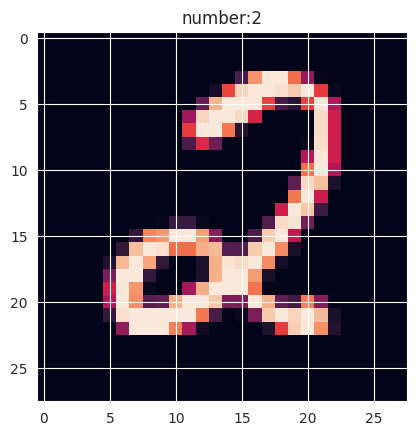

In [6]:
from mindspore import context
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

context.set_context(mode=context.GRAPH_MODE,
                    device_target="CPU")  # Windows version, set to use CPU for graph calculation
train_data_path = "./data/train"
test_data_path = "./data/test"
mnist_ds = ds.MnistDataset(train_data_path)  # Load training dataset
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())  # 60000 pictures in total

dic_ds = mnist_ds.create_dict_iterator()  # Convert dataset to dictionary type
item = dic_ds.__next__()
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:",
      item.keys())  # Take a single data to view the data structure, including two keys, image and label
print("Tensor of image in item:", img.shape)  # View the tensor of image (28,28,1)
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s" % item["label"])
plt.show()

In [7]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ create dataset for train or test
    Args:
        data_path: Data path
        batch_size: The number of data records in each group
        repeat_size: The number of replicated data records
        num_parallel_workers: The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # Define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # According to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width),
                          interpolation=Inter.LINEAR)  # Resize images to (32, 32) by bilinear interpolation
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)  # normalize images
    rescale_op = CV.Rescale(rescale, shift)  # rescale images
    hwc2chw_op = CV.HWC2CHW()  # change shape from (height, width, channel) to (channel, height, width) to fit network.
    type_cast_op = C.TypeCast(mstype.int32)  # change data type of label to int32 to fit network

    # Using map () to apply operations to a dataset
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)
    # Process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)  # 10000 as in LeNet train script
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

In [8]:
datas = create_dataset(train_data_path)  # Process the train dataset
print('Number of groups in the dataset:', datas.get_dataset_size())  # Number of query dataset groups

[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:30.764.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:30.764.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:30.764.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:30.765.000 [mindspore/dataset

Number of groups in the dataset: 1875


In [9]:
data = datas.create_dict_iterator().__next__()  # Take a set of datasets
print(data.keys())
images = data["image"].asnumpy()  # Take out the image data in this dataset
labels = data["label"].asnumpy()  # Take out the label (subscript) of this data set
print('Tensor of image:', images.shape)  # Query the tensor of images in each dataset (32,1,32,32)
print('labels:', labels)

dict_keys(['image', 'label'])
Tensor of image: (32, 1, 32, 32)
labels: [2 5 9 0 4 6 9 6 1 7 7 8 5 3 0 0 5 5 5 6 5 0 7 9 9 8 6 7 9 7 4 6]


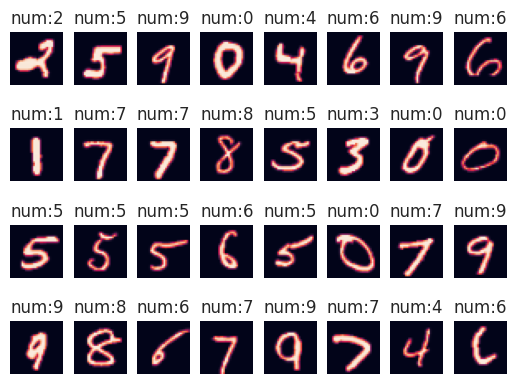

In [10]:
count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s' % labels[count - 1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()  # Print a total of 32 pictures in the group

In [11]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


# Initialize 2D convolution function
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Conv layer weight initial."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


# Initialize full connection layer
def fc_with_initialize(input_channels, out_channels):
    """Fc layer weight initial."""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


# Set truncated normal distribution
def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)

In [12]:
class LeNet5(nn.Cell):
    """Lenet network structure."""

    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32  # 32 pictures in each group
        self.conv1 = conv(1, 6,
                          5)  # Convolution layer 1, 1 channel input (1 Figure), 6 channel output (6 figures), convolution core 5 * 5
        self.conv2 = conv(6, 16, 5)  # Convolution layer 2,6-channel input, 16 channel output, convolution kernel 5 * 5
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.conv1(x)  # 1*32*32-->6*28*28
        x = self.relu(x)  # 6*28*28-->6*14*14
        x = self.max_pool2d(x)  # Pool layer
        x = self.conv2(x)  # Convolution layer
        x = self.relu(x)  # Function excitation layer
        x = self.max_pool2d(x)  # Pool layer
        x = self.flatten(x)  # Dimensionality reduction
        x = self.fc1(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc2(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc3(x)  # Full connection
        return x

In [13]:
network = LeNet5()
print(network)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x75e5d1b96fb0>, bias_init=None, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x75e5ae003430>, bias_init=None, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


In [14]:
param = network.trainable_params()
param

[Parameter (name=conv1.weight, shape=(6, 1, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=conv2.weight, shape=(16, 6, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.weight, shape=(120, 400), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.bias, shape=(120,), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.weight, shape=(84, 120), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.bias, shape=(84,), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.weight, shape=(10, 84), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.bias, shape=(10,), dtype=Float32, requires_grad=True)]

In [15]:
# Training and testing related modules
import argparse
import os
from mindspore import Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits


def train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info):
    """Define the training method."""
    print("============== Starting Training ==============")
    # load training dataset
    ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), step_loss_info], dataset_sink_mode=True)

In [16]:
# Custom callback function
class Step_loss_info(Callback):
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # step_ Loss dictionary for saving loss value and step number information
        step_loss["loss_value"].append(str(cb_params.net_outputs))
        step_loss["step"].append(str(cb_params.cur_step_num))

In [17]:
import os

if os.name == "nt":
    os.system('del/f/s/q *.ckpt *.meta')  # Clean up old run files before in Windows
else:
    os.system('rm -f *.ckpt *.meta *.pb')  # Clean up old run files before in Linux

lr = 0.01  # learning rate
momentum = 0.9  #

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
epoch_size = 10
mnist_path = "./data"

config_ck = CheckpointConfig(save_checkpoint_steps=125, keep_checkpoint_max=16)
# save the network model and parameters for subsequence fine-tuning

ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck, directory="./checkpoints")
# group layers into an object with training and evaluation features
step_loss = {"step": [], "loss_value": []}
# step_ Loss dictionary for saving loss value and step number information
step_loss_info = Step_loss_info()
# save the steps and loss value
repeat_size = 1
train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info)

[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:31.929.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:31.929.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:31.930.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:26:31.930.000 [mindspore/dataset

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.299901008605957
epoch: 1 step: 2, loss is 2.303295373916626
epoch: 1 step: 3, loss is 2.2998125553131104
epoch: 1 step: 4, loss is 2.3018369674682617
epoch: 1 step: 5, loss is 2.3016414642333984
epoch: 1 step: 6, loss is 2.2979884147644043
epoch: 1 step: 7, loss is 2.3042800426483154
epoch: 1 step: 8, loss is 2.3033785820007324
epoch: 1 step: 9, loss is 2.307173490524292
epoch: 1 step: 10, loss is 2.304697036743164
epoch: 1 step: 11, loss is 2.306187152862549
epoch: 1 step: 12, loss is 2.301429510116577
epoch: 1 step: 13, loss is 2.299933671951294
epoch: 1 step: 14, loss is 2.3036985397338867
epoch: 1 step: 15, loss is 2.3019354343414307
epoch: 1 step: 16, loss is 2.305600166320801
epoch: 1 step: 17, loss is 2.2988944053649902
epoch: 1 step: 18, loss is 2.2988169193267822
epoch: 1 step: 19, loss is 2.303699493408203
epoch: 1 step: 20, loss is 2.3090457916259766
epoch: 1 step: 21, loss is 2.297564744949341
epoch

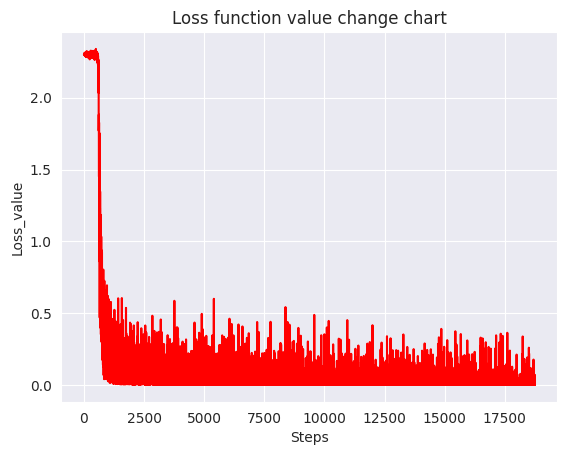

In [22]:
steps = step_loss["step"]
loss_value = step_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Loss function value change chart")
plt.show()

In [23]:
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=True)
    print("============== Accuracy:{} ==============".format(acc))


test_net(network, model, mnist_path)

[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:08.221.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:08.222.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:08.222.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:08.222.000 [mindspore/dataset

============== Starting Testing ==============
============== Accuracy:{'Accuracy': np.float64(0.9899839743589743)} ==============


[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:10.684.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:10.685.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:10.685.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:10.685.000 [mindspore/dataset

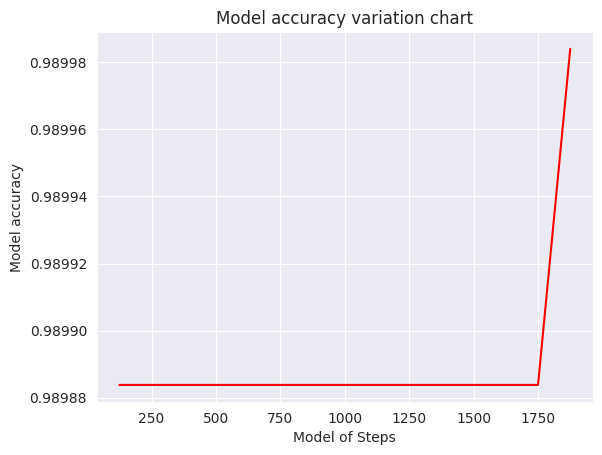

In [24]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size + 1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        #param_dict = load_checkpoint("checkpoint_lenet-{}_1875.ckpt".format(str(i)))

        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers + 1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i * 125)
    return step_list, acc_list


# Draw line chart according to training steps and model accuracy
l1, l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

In [25]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size + 1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        # param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-10_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("./checkpoints/checkpoint_lenet-{}_1875.ckpt".format(str(i)))

        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers + 1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i * 125)
    return step_list, acc_list


# Draw line chart according to training steps and model accuracy
l1, l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

ValueError: For 'load_checkpoint', the checkpoint file: /home/grtsinry43/PycharmProjects/JupyterProject/checkpoints/checkpoint_lenet-1_1875.ckpt does not exist, please check whether the 'ckpt_file_name' is correct.

[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:36.910.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:36.911.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:36.911.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:44:36.911.000 [mindspore/dataset

All the figures in this group are predicted correctly！
[9 6 2 7 8 4 4 0 7 1 9 8 0 8 3 9 7 0 6 1 1 0 9 8 6 7 6 3 2 0 0 5] <--Predicted figures
[9 6 2 7 8 4 4 0 7 1 9 8 0 8 3 9 7 0 6 1 1 0 9 8 6 7 6 3 2 0 0 5] <--The right number


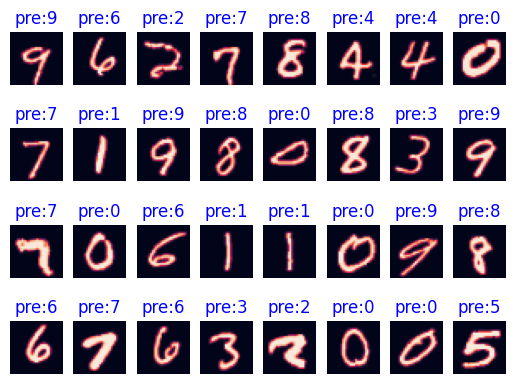

In [26]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = ds_test.__next__()
images = data["image"].asnumpy()
labels = data[
    "label"].asnumpy()  # The subscript of data picture is the standard for us to judge whether it is correct or not

output = model.predict(Tensor(data['image']))
# The predict function returns the probability of 0-9 numbers corresponding to each picture
prb = output.asnumpy()
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i + 1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        # Print out the wrong data identified by the current group
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i / 8) + 1,
                                                                                                         i % 8 + 1,
                                                                                                         pred[i],
                                                                                                         labels[i]),
              '\n')
if index:
    print("All the figures in this group are predicted correctly！")
print(pred, "<--Predicted figures")  # Print the numbers recognized by each group of pictures
print(labels, "<--The right number")  # Print the subscript corresponding to each group of pictures
plt.show()

Figure 1 probability of corresponding numbers [0-9]:
 [ -6.763879  -10.332399   -7.613531   -2.8446858  12.078036   -2.3978648
 -19.046787    4.1482215   1.3607234  30.924307 ]


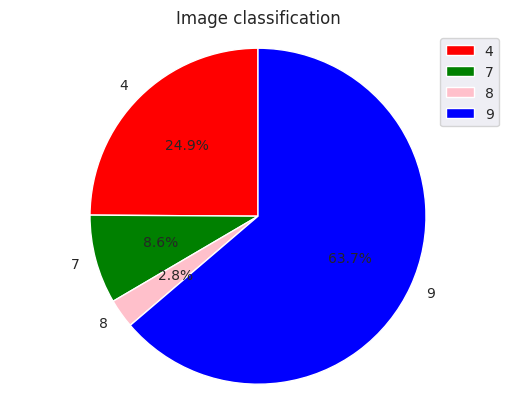

Figure 2 probability of corresponding numbers [0-9]:
 [  4.257677   -1.9731985   1.6863294 -10.233752    2.5221639   3.7849915
  26.514875  -14.962747   -2.6158319  -7.3505726]


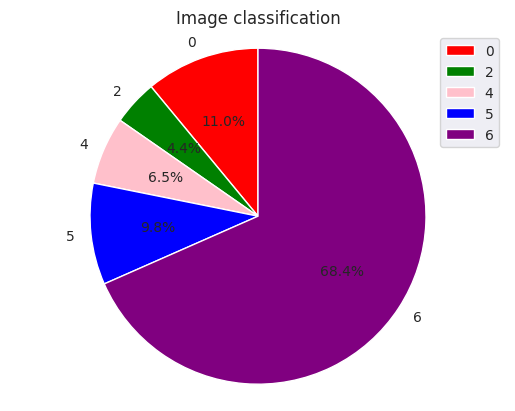

In [27]:
# define the pie drawing function of probability analysis
def plot_pie(prbs):
    dict1 = {}
    # Remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()  # Label of each part
    size = dict1.values()  # Size of each part
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"]  # Building a round cake pigment Library
    color = colors[: len(size)]  # Color of each part
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90,
            pctdistance=0.6)
    plt.axis("equal")  # Set the scale size of x-axis and y-axis to be equal
    plt.legend()
    plt.title("Image classification")
    plt.show()


for i in range(2):
    print("Figure {} probability of corresponding numbers [0-9]:\n".format(i + 1), prb[i])
    plot_pie(prb[i])

ii. 将上述模型稍加修改，迁移到美国邮政编码手写数字集的数字识别上，检测识别率并进行改进。
iii. 试试用前期遗传算法生成的手写数字图像，看看效果如何。

In [38]:
import h5py
import os
import mindspore.dataset as ds
import numpy as np
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Inter
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype
from mindspore import Tensor

class USPSDataset:
    def __init__(self, data_path, is_train=True):
        with h5py.File(data_path, 'r') as hf:
            if is_train:
                train = hf.get('train')
                self.X = train.get('data')[:]
                self.y = train.get('target')[:]
            else:
                test = hf.get('test')
                self.X = test.get('data')[:]
                self.y = test.get('target')[:]

        # USPS original size is 16x16, needs to be converted to the appropriate format
        self.X = self.X.reshape((-1, 16, 16, 1)).astype(np.float32)
        self.y = self.y.astype(np.int32)

    def __getitem__(self, idx):
        return np.asarray(self.X[idx]), np.asarray(self.y[idx])

    def __len__(self):
        return len(self.X)


import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Inter
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype

def create_usps_dataset(data_path, batch_size=32, repeat_size=1, num_parallel_workers=1, is_train=True):
    # 创建USPS数据集
    usps_dataset = USPSDataset(data_path, is_train)
    dataset_generator = ds.GeneratorDataset(
        usps_dataset, ["image", "label"], shuffle=is_train)

    # 数据预处理操作
    resize_height, resize_width = 32, 32

    # 定义与MNIST相同的操作
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_op = CV.Rescale(1.0 / 255.0, 0.0)
    rescale_nml_op = CV.Rescale(1 / 0.3081, -1 * 0.1307 / 0.3081)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # 应用操作
    dataset_generator = dataset_generator.map(operations=type_cast_op, input_columns=["label"])
    dataset_generator = dataset_generator.map(operations=resize_op, input_columns=["image"])
    dataset_generator = dataset_generator.map(operations=rescale_op, input_columns=["image"])
    dataset_generator = dataset_generator.map(operations=rescale_nml_op, input_columns=["image"])
    dataset_generator = dataset_generator.map(operations=hwc2chw_op, input_columns=["image"])

    # 批处理
    buffer_size = 10000
    if is_train:
        dataset_generator = dataset_generator.shuffle(buffer_size=buffer_size)
    dataset_generator = dataset_generator.batch(batch_size, drop_remainder=True)
    dataset_generator = dataset_generator.repeat(repeat_size)

    return dataset_generator

In [39]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
import mindspore.nn as nn


def transfer_learning_usps(network, pretrained_ckpt_path, usps_data_path, epoch_size=5):
    # 加载预训练的LeNet5网络参数
    param_dict = load_checkpoint(pretrained_ckpt_path)
    load_param_into_net(network, param_dict)

    # 微调设置 - 可以选择冻结部分层
    # 仅训练全连接层
    for param in network.trainable_params():
        if "fc3" not in param.name:
            param.requires_grad = False

    # 定义优化器（使用较小的学习率进行微调）
    lr = 0.001
    net_opt = nn.Momentum(network.trainable_params(), lr, momentum=0.9)

    # 定义损失函数和模型
    net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

    # 定义回调函数
    step_loss = {"step": [], "loss_value": []}

    class Step_loss_info(Callback):
        def step_end(self, run_context):
            cb_params = run_context.original_args()
            step_loss["loss_value"].append(str(cb_params.net_outputs))
            step_loss["step"].append(str(cb_params.cur_step_num))

    config_ck = CheckpointConfig(save_checkpoint_steps=50, keep_checkpoint_max=10)
    ckpoint_cb = ModelCheckpoint(prefix="usps_lenet", config=config_ck, directory="./usps_checkpoints")

    # 加载USPS数据集
    ds_train = create_usps_dataset(usps_data_path, batch_size=32, is_train=True)

    # 训练模型
    print("============== Starting USPS Transfer Learning ==============")
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), Step_loss_info()], dataset_sink_mode=True)

    # 评估USPS测试集
    ds_eval = create_usps_dataset(usps_data_path, batch_size=32, is_train=False)
    acc = model.eval(ds_eval, dataset_sink_mode=True)
    print("============== USPS Accuracy: {} ==============".format(acc))

    return model

In [40]:
class ImprovedLeNet5(nn.Cell):
    """添加批归一化和dropout的改进LeNet模型"""

    def __init__(self):
        super(ImprovedLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, pad_mode="valid")
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, pad_mode="valid")
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Dense(64 * 5 * 5, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Dense(512, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Dense(128, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [41]:
import matplotlib.pyplot as plt


def visualize_results(model, usps_data_path):
    # 加载测试数据
    ds_test = create_usps_dataset(usps_data_path, batch_size=32, is_train=False)
    data = next(ds_test.create_dict_iterator())

    # 预测
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 可视化
    plt.figure(figsize=(12, 8))
    for i in range(min(32, len(labels))):
        plt.subplot(4, 8, i + 1)
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title("pre:{}".format(pred[i]), color=color)
        plt.imshow(np.squeeze(images[i]))
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # 计算准确率
    correct = (pred == labels).sum()
    total = len(labels)
    print(f"Accuracy: {correct / total * 100:.2f}%")


def test_genetic_algo_images(model, image_folder):
    """测试遗传算法生成的图像"""
    from PIL import Image
    import os

    # 加载图像
    images = []
    labels = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # 从文件名中提取标签（假设格式为"digit_5.png"）
            try:
                label = int(filename.split("_")[1].split(".")[0])
                # 加载并预处理图像
                img_path = os.path.join(image_folder, filename)
                img = Image.open(img_path).convert('L')  # 转为灰度图
                img = img.resize((32, 32))  # 调整大小匹配模型输入
                img_array = np.array(img).reshape(1, 32, 32, 1).astype(np.float32)

                # 应用与训练数据相同的预处理
                img_array = img_array / 255.0
                img_array = (img_array - 0.1307) / 0.3081
                img_array = np.transpose(img_array, (0, 3, 1, 2))  # NHWC到NCHW

                images.append(img_array)
                labels.append(label)
            except:
                print(f"跳过文件 {filename} - 格式不正确")

    # 合并所有图像
    if images:
        all_images = np.vstack(images)
        all_labels = np.array(labels)

        # 预测
        input_tensor = Tensor(all_images)
        output = model.predict(input_tensor)
        pred = np.argmax(output.asnumpy(), axis=1)

        # 显示结果
        fig, axes = plt.subplots(len(images), 2, figsize=(8, 4 * len(images)))

        for i in range(len(images)):
            if len(images) == 1:  # 处理只有一张图片的特殊情况
                ax1, ax2 = axes
            else:
                ax1, ax2 = axes[i]

            ax1.imshow(np.squeeze(images[i]), cmap='gray')
            ax1.set_title(f"真实标签: {labels[i]}")
            ax1.axis('off')

            # 绘制预测概率
            probs = output.asnumpy()[i]
            ax2.bar(range(10), probs)
            ax2.set_title(f"预测: {pred[i]} (概率: {probs[pred[i]]:.2f})")
            ax2.set_xticks(range(10))

        plt.tight_layout()
        plt.show()

        # 计算准确率
        correct = (pred == all_labels).sum()
        total = len(all_labels)
        print(f"遗传算法图像准确率: {correct / total * 100:.2f}%")
    else:
        print("在指定文件夹中没有找到有效图像")

[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:32.336.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:32.337.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:32.337.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:32.337.000 [mindspore/dataset

============== Starting USPS Transfer Learning ==============
epoch: 1 step: 1, loss is 2.3268587589263916
epoch: 1 step: 2, loss is 2.340838670730591
epoch: 1 step: 3, loss is 2.2978248596191406
epoch: 1 step: 4, loss is 2.2920548915863037
epoch: 1 step: 5, loss is 2.298778533935547
epoch: 1 step: 6, loss is 2.3431034088134766
epoch: 1 step: 7, loss is 2.3236377239227295
epoch: 1 step: 8, loss is 2.3582680225372314
epoch: 1 step: 9, loss is 2.310331106185913
epoch: 1 step: 10, loss is 2.295938491821289
epoch: 1 step: 11, loss is 2.273242712020874
epoch: 1 step: 12, loss is 2.3156514167785645
epoch: 1 step: 13, loss is 2.296466588973999
epoch: 1 step: 14, loss is 2.326814889907837
epoch: 1 step: 15, loss is 2.319678783416748
epoch: 1 step: 16, loss is 2.3130016326904297
epoch: 1 step: 17, loss is 2.28810715675354
epoch: 1 step: 18, loss is 2.3414955139160156
epoch: 1 step: 19, loss is 2.3910508155822754
epoch: 1 step: 20, loss is 2.297266960144043
epoch: 1 step: 21, loss is 2.289071083

[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:35.922.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:35.923.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:35.923.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:35.923.000 [mindspore/dataset

============== USPS Accuracy: {'Accuracy': np.float64(0.17842741935483872)} ==============


[ERROR] CORE(7418,75e66731b640,python):2025-04-07-15:48:36.213.747 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_7418/2100403872.py]
[WARNING] CORE(7418,75e66731b640,python):2025-04-07-15:48:36.213.759 [mindspore/core/utils/info.cc:121] ToString] The file '/tmp/ipykernel_7418/2100403872.py' may not exists.


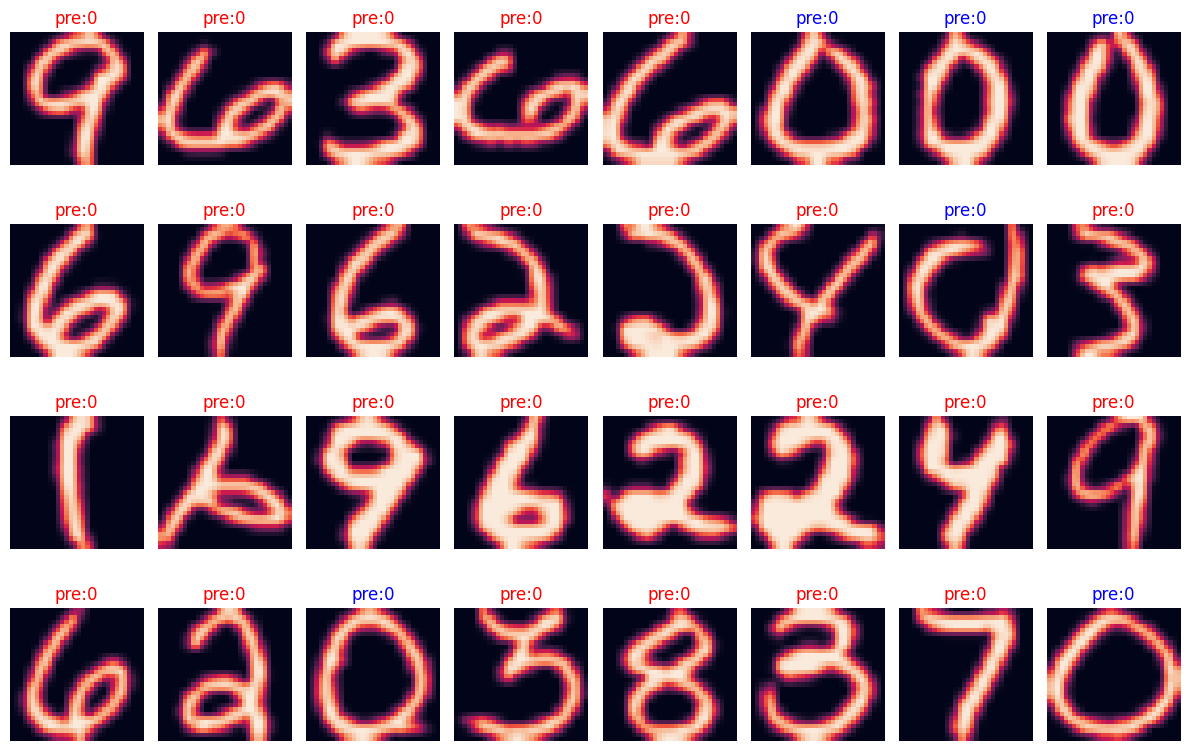

[WARNING] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:37.125.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[CRITICAL] ME(7418:129632434239040,MainProcess):2025-04-07-15:48:37.128.000 [mindspore/train/serialization.py:257] Failed to combine the net and the parameters for param conv1.weight.


Accuracy: 18.75%


RuntimeError: For 'load_param_into_net', conv1.weight in the argument 'net' should have the same shape as conv1.weight in the argument 'parameter_dict'. But got its shape (32, 1, 5, 5) in the argument 'net' and shape (6, 1, 5, 5) in the argument 'parameter_dict'.May you need to check whether the checkpoint you loaded is correct or the batch size and so on in the 'net' and 'parameter_dict' are same.

In [42]:
# 主函数 - 运行整个迁移学习过程
def main():
    # 初始化LeNet5网络
    network = LeNet5()

    # 设定路径
    pretrained_model_path = "./checkpoints/checkpoint_lenet-10_1875.ckpt"  # MNIST预训练模型
    usps_data_path = "./data/usps/usps.h5"  # USPS数据集路径
    genetic_images_path = "./genetic_algorithm_images/"  # 遗传算法生成图像的文件夹

    # 执行迁移学习
    model = transfer_learning_usps(network, pretrained_model_path, usps_data_path, epoch_size=5)

    # 可视化USPS数据集上的结果
    visualize_results(model, usps_data_path)

    # 使用改进的模型（可选）
    improved_network = ImprovedLeNet5()
    improved_model = transfer_learning_usps(improved_network, pretrained_model_path, usps_data_path, epoch_size=5)

    # 测试遗传算法生成的图像
    test_genetic_algo_images(model, genetic_images_path)

    # 比较原始模型和改进模型的性能（可选）
    ds_eval = create_usps_dataset(usps_data_path, batch_size=32, is_train=False)
    original_acc = model.eval(ds_eval, dataset_sink_mode=True)
    improved_acc = improved_model.eval(ds_eval, dataset_sink_mode=True)

    print(f"原始LeNet5在USPS上的准确率: {original_acc['Accuracy'] * 100:.2f}%")
    print(f"改进LeNet5在USPS上的准确率: {improved_acc['Accuracy'] * 100:.2f}%")


# 执行主函数
if __name__ == "__main__":
    main()